<a href="https://colab.research.google.com/github/JuanCamiloArrietaCamacho/Parcial-2-IA/blob/main/Parcial_2_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install --upgrade pip
!pip install pandas numpy matplotlib seaborn scikit-learn torch torchvision torchaudio --quiet
!pip install imbalanced-learn tqdm optuna --quiet
!pip install torchmetrics --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [6]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix,
                             classification_report)

from imblearn.over_sampling import SMOTE

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [7]:
!unzip -o adult.zip -d ./adult_data || true
DATA_DIR = Path("./adult_data")
print("Archivos en data dir:", list(DATA_DIR.glob("*")) )


Archive:  adult.zip
  inflating: ./adult_data/Index      
  inflating: ./adult_data/adult.data  
  inflating: ./adult_data/adult.names  
  inflating: ./adult_data/adult.test  
  inflating: ./adult_data/old.adult.names  
Archivos en data dir: [PosixPath('adult_data/adult.data'), PosixPath('adult_data/adult.names'), PosixPath('adult_data/old.adult.names'), PosixPath('adult_data/Index'), PosixPath('adult_data/adult.test')]


In [8]:
# Carga de datos
train_path = DATA_DIR / "adult.data"
test_path  = DATA_DIR / "adult.test"

column_names = [
 "age","workclass","fnlwgt","education","education-num","marital-status",
 "occupation","relationship","race","sex","capital-gain","capital-loss",
 "hours-per-week","native-country","income"
]

# Cargar train
df_train = pd.read_csv(train_path, header=None, names=column_names, na_values="?", skipinitialspace=True)
# Cargar test
df_test = pd.read_csv(test_path, header=0, names=column_names, na_values="?", skipinitialspace=True, comment='|')
# limpiar
df_test['income'] = df_test['income'].apply(lambda x: x.rstrip('.') if isinstance(x, str) else x)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
display(df_train.head())


Train shape: (32561, 15)
Test shape: (16280, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
# Split para validación
df_val, df_test_final = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, stratify=df_test['income'])
print("Validation:", df_val.shape, "Test final:", df_test_final.shape)


Validation: (8140, 15) Test final: (8140, 15)


In [10]:
# EDA
def eda_report(df):
    print("Forma:", df.shape)
    display(df.describe(include='all').transpose())
    print("\nValores faltantes:")
    print(df.isna().sum())
    print("\nDistribución de ingreso:")
    display(df['income'].value_counts(normalize=True))

print("EDA entrenamiento")
eda_report(df_train)
print("EDA Validación")
eda_report(df_val)


EDA entrenamiento
Forma: (32561, 15)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,32561.0,NaN,NaN,NaN,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
workclass,30725,8,Private,22696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,32561.0,NaN,NaN,NaN,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education,32561,16,HS-grad,10501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education-num,32561.0,NaN,NaN,NaN,10.080679,2.57272,1.0,9.0,10.0,12.0,16.0
marital-status,32561,7,Married-civ-spouse,14976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,30718,14,Prof-specialty,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,32561,6,Husband,13193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,32561,5,White,27816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,32561,2,Male,21790,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Valores faltantes:
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

Distribución de ingreso:


,proportion
income,
<=50K,0.75919
>50K,0.24081


EDA Validación
Forma: (8140, 15)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,8140.0,NaN,NaN,NaN,38.71855,13.924004,17.0,28.0,37.0,48.0,90.0
workclass,7671,7,Private,5584,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,8140.0,NaN,NaN,NaN,189608.490663,106163.226532,13492.0,116542.25,177610.5,240185.0,1210504.0
education,8140,16,HS-grad,2629,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education-num,8140.0,NaN,NaN,NaN,10.068919,2.596139,1.0,9.0,10.0,13.0,16.0
marital-status,8140,7,Married-civ-spouse,3706,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,7671,14,Prof-specialty,1012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,8140,6,Husband,3265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,8140,5,White,6940,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,8140,2,Male,5446,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Valores faltantes:
age                 0
workclass         469
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        469
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    133
income              0
dtype: int64

Distribución de ingreso:


,proportion
income,
<=50K,0.763759
>50K,0.236241


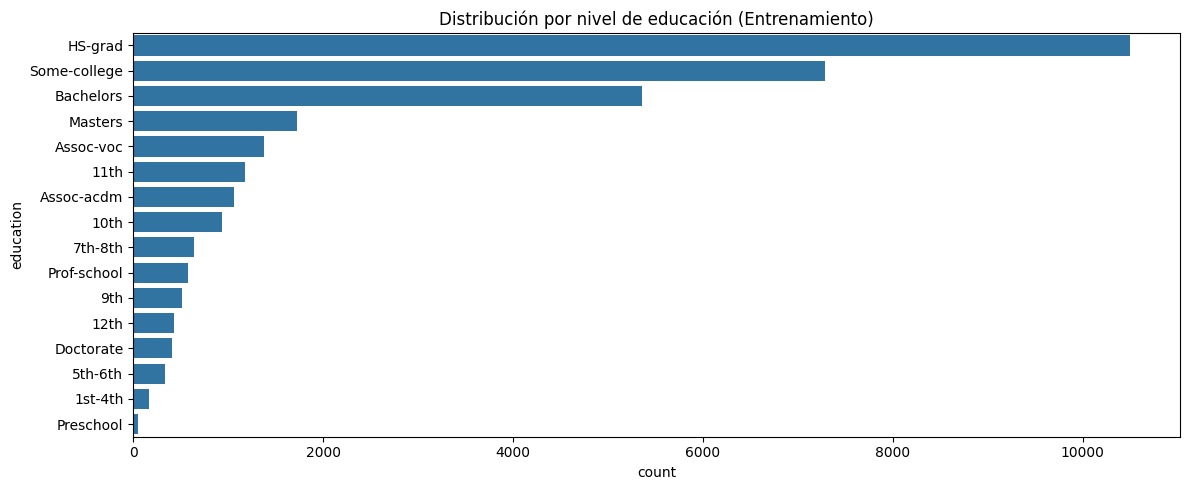

In [11]:
# Visualizaciones
plt.figure(figsize=(12,5))
sns.countplot(y='education', data=df_train, order=df_train['education'].value_counts().index)
plt.title("Distribución por nivel de educación (Entrenamiento)")
plt.tight_layout()


In [12]:
# Preprocesamiento

# Definir features
target = "income"
num_features = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]
cat_features = ["workclass","education","marital-status","occupation","relationship","race","sex","native-country"]

# Preprocesador para sklearn
from sklearn.impute import SimpleImputer

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

In [13]:
# Fit del preprocessor en TRAIN y transformación de splits
X_train = df_train.drop(columns=[target])
y_train = (df_train[target] == ">50K").astype(int)

X_val = df_val.drop(columns=[target])
y_val = (df_val[target] == ">50K").astype(int)

X_test = df_test_final.drop(columns=[target])
y_test = (df_test_final[target] == ">50K").astype(int)

# Ajustar preprocesador con TRAIN
preprocessor.fit(X_train)

# Transformar
X_train_t = preprocessor.transform(X_train)
X_val_t   = preprocessor.transform(X_val)
X_test_t  = preprocessor.transform(X_test)

print("Shapes transformed:", X_train_t.shape, X_val_t.shape, X_test_t.shape)


ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_cols = ohe.get_feature_names_out(cat_features)
feature_names = num_features + list(cat_cols)
print("Num features after transform:", len(feature_names))


Shapes transformed: (32561, 108) (8140, 108) (8140, 108)
Num features after transform: 108


In [14]:
# Balanceo
print("Distribución de etiquetas de entrenamiento:")
print(y_train.value_counts(normalize=True))

sm = SMOTE(random_state=RANDOM_SEED)
X_train_bal, y_train_bal = sm.fit_resample(X_train_t, y_train)
print("Después de SMOTE:", pd.Series(y_train_bal).value_counts(normalize=True))


Distribución de etiquetas de entrenamiento:
income
0    0.75919
1    0.24081
Name: proportion, dtype: float64
Después de SMOTE: income
0    0.5
1    0.5
Name: proportion, dtype: float64


In [15]:
# Baseline regresión Logística
clf = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
clf.fit(X_train_bal, y_train_bal)

def eval_print(model, X_tr, y_tr, X_v, y_v, X_te, y_te):
    for name, X, y in [("Entrenamiento", X_tr, y_tr), ("Validación", X_v, y_v), ("Prueba", X_te, y_te)]:
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X)
        print(f"=== {name} ===")
        print("Accuracy:", accuracy_score(y, y_pred))
        print("Precisión:", precision_score(y, y_pred))
        print("Recall:", recall_score(y, y_pred))
        print("F1:", f1_score(y, y_pred))
        print("ROC AUC:", roc_auc_score(y, y_proba))
        print(confusion_matrix(y, y_pred))
        print()

eval_print(clf, X_train_bal, y_train_bal, X_val_t, y_val, X_test_t, y_test)


=== Entrenamiento ===
Accuracy: 0.8297734627831715
Precisión: 0.8127445714724162
Recall: 0.8569983818770227
F1: 0.8342850391840271
ROC AUC: 0.9120642694947163
[[19839  4881]
 [ 3535 21185]]

=== Validación ===
Accuracy: 0.8099508599508599
Precisión: 0.56657223796034
Recall: 0.8320332813312532
F1: 0.6741099641879081
ROC AUC: 0.9006348737140735
[[4993 1224]
 [ 323 1600]]

=== Prueba ===
Accuracy: 0.8073710073710074
Precisión: 0.5619979042961928
Recall: 0.8367134685387415
F1: 0.6723777684914334
ROC AUC: 0.9075753572204975
[[4963 1254]
 [ 314 1609]]



In [16]:
# Conversión de datos a tensores
X_train_tensor = torch.tensor(X_train_bal.toarray().astype(np.float32))
y_train_tensor = torch.tensor(y_train_bal.astype(np.float32)).unsqueeze(1)

X_val_tensor = torch.tensor(X_val_t.toarray().astype(np.float32))
y_val_tensor = torch.tensor(y_val.to_numpy().astype(np.float32)).unsqueeze(1) # Convert y_val to numpy array

X_test_tensor = torch.tensor(X_test_t.toarray().astype(np.float32))
y_test_tensor = torch.tensor(y_test.to_numpy().astype(np.float32)).unsqueeze(1) # Convert y_test to numpy array

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

In [17]:
# MLP en PyTorch
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[128,64], dropout=0.0):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            if dropout>0:
                layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.net(x))


In [18]:
# EarlyStopping utility
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            return False
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        else:
            self.best_score = score
            self.counter = 0
            return False


In [19]:
# Training loop
def train_model(model, train_loader, val_loader, n_epochs, lr, weight_decay=0.0, patience=7):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    es = EarlyStopping(patience=patience, verbose=False)

    history = {"train_loss":[], "val_loss":[], "val_auc":[]}
    best_model_wts = None
    best_val_loss = np.inf

    for epoch in range(1, n_epochs+1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)

        # validación
        model.eval()
        val_losses = []
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())
                all_preds.append(preds.cpu().numpy())
                all_targets.append(yb.cpu().numpy())

        avg_val_loss = np.mean(val_losses)
        preds_concat = np.vstack(all_preds)
        targets_concat = np.vstack(all_targets)
        try:
            val_auc = roc_auc_score(targets_concat, preds_concat)
        except:
            val_auc = np.nan

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_auc"].append(val_auc)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = {k: v.cpu() for k, v in model.state_dict().items()}

        if es(avg_val_loss):
            print(f"Stopped early at epoch {epoch}")
            break

    # cargar mejores pesas
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    return model, history


Running Experimento1
Stopped early at epoch 12


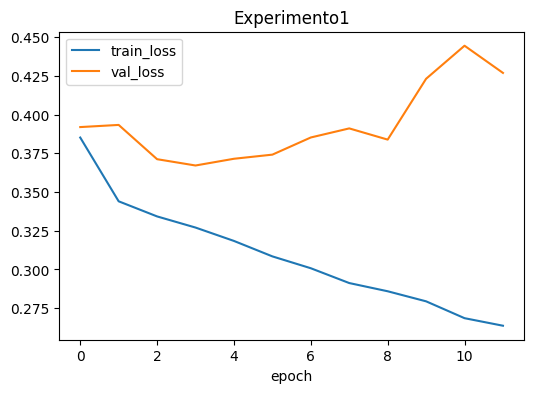

Running Experimento2
Stopped early at epoch 16


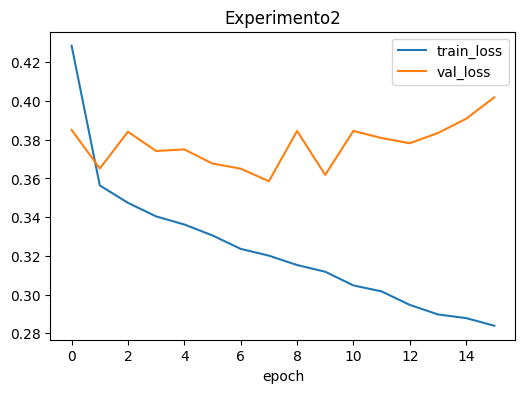

Running Experimento3
Stopped early at epoch 25


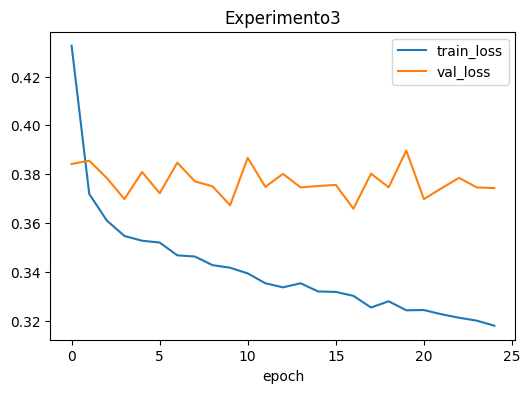

Running Experimento4
Stopped early at epoch 30


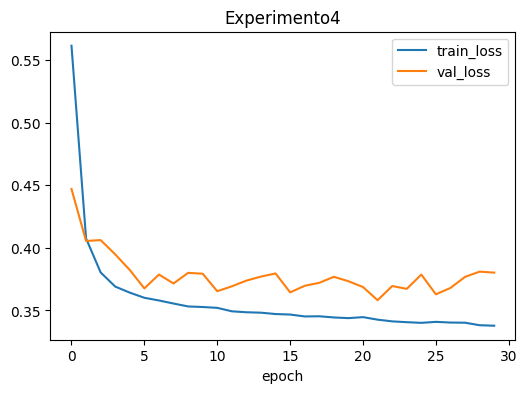

Running Experimento5
Stopped early at epoch 21


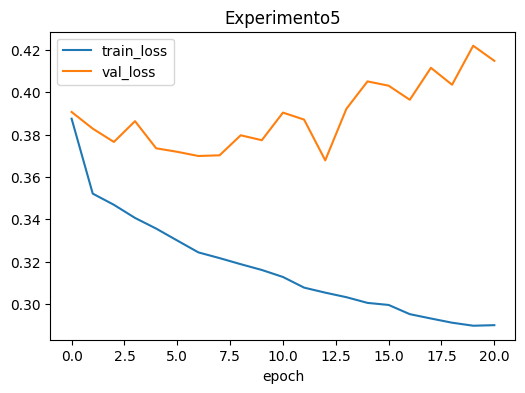

In [20]:
# Experimentos: Se definen 5 configuraciones de hiperparámetros
input_dim = X_train_tensor.shape[1]
experiments = [
    {"name":"Experimento1", "hidden":[256,128], "dropout":0.0, "lr":1e-3, "weight_decay":0.0, "batch_size":256, "epochs":50},
    {"name":"Experimento2", "hidden":[512,256,128], "dropout":0.2, "lr":5e-4, "weight_decay":1e-4, "batch_size":512, "epochs":80},
    {"name":"Experimento3", "hidden":[128,64], "dropout":0.5, "lr":1e-3, "weight_decay":1e-5, "batch_size":256, "epochs":100},
    {"name":"Experimento4", "hidden":[1024,512], "dropout":0.3, "lr":1e-4, "weight_decay":1e-3, "batch_size":1024, "epochs":60},
    {"name":"Experimento5", "hidden":[64,32], "dropout":0.1, "lr":2e-3, "weight_decay":0.0, "batch_size":128, "epochs":40},
]

results = {}
for cfg in experiments:
    print("Running", cfg["name"])
    model = MLP(input_dim=input_dim, hidden_layers=cfg["hidden"], dropout=cfg["dropout"])
    train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=False)
    trained_model, history = train_model(model, train_loader, val_loader, n_epochs=cfg["epochs"], lr=cfg["lr"], weight_decay=cfg["weight_decay"], patience=8)
    results[cfg["name"]] = {"model": trained_model, "history": history, "config": cfg}
    # plot loss
    plt.figure(figsize=(6,4))
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.title(cfg["name"])
    plt.xlabel("epoch")
    plt.legend()
    plt.show()


In [21]:
# Evaluación mejor modelo
def evaluate_torch_model(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor.to(device)).cpu().numpy()
    y_true = y_tensor.cpu().numpy()
    y_pred_label = (preds >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y_true, y_pred_label),
        "precision": precision_score(y_true, y_pred_label),
        "recall": recall_score(y_true, y_pred_label),
        "f1": f1_score(y_true, y_pred_label),
        "roc_auc": roc_auc_score(y_true, preds),
        "preds": preds
    }

summary = []
for k,v in results.items():
    print("----", k)
    eval_val = evaluate_torch_model(v["model"], X_val_tensor, y_val_tensor)
    eval_test = evaluate_torch_model(v["model"], X_test_tensor, y_test_tensor)
    print("Val:", {k2:round(v2,4) for k2,v2 in eval_val.items() if k2!='preds'})
    print("Test:", {k2:round(v2,4) for k2,v2 in eval_test.items() if k2!='preds'})
    summary.append((k, eval_val['roc_auc']))

# Se selecciona mejor por AUC en validación
best_exp = max(results.keys(), key=lambda x: evaluate_torch_model(results[x]["model"], X_val_tensor, y_val_tensor)['roc_auc'])
print("Best experiment by val AUC:", best_exp)
best_model = results[best_exp]["model"]


---- Experimento1
Val: {'accuracy': 0.8173, 'precision': 0.5827, 'recall': 0.7988, 'f1': 0.6738, 'roc_auc': np.float64(0.9014)}
Test: {'accuracy': 0.8204, 'precision': 0.5863, 'recall': 0.8144, 'f1': 0.6818, 'roc_auc': np.float64(0.9079)}
---- Experimento2
Val: {'accuracy': 0.8253, 'precision': 0.6008, 'recall': 0.7764, 'f1': 0.6774, 'roc_auc': np.float64(0.9019)}
Test: {'accuracy': 0.8301, 'precision': 0.6065, 'recall': 0.7998, 'f1': 0.6898, 'roc_auc': np.float64(0.9092)}
---- Experimento3
Val: {'accuracy': 0.8205, 'precision': 0.5877, 'recall': 0.805, 'f1': 0.6794, 'roc_auc': np.float64(0.9046)}
Test: {'accuracy': 0.8216, 'precision': 0.5876, 'recall': 0.8211, 'f1': 0.685, 'roc_auc': np.float64(0.9096)}
---- Experimento4
Val: {'accuracy': 0.823, 'precision': 0.5921, 'recall': 0.806, 'f1': 0.6827, 'roc_auc': np.float64(0.9074)}
Test: {'accuracy': 0.8273, 'precision': 0.5967, 'recall': 0.8294, 'f1': 0.6941, 'roc_auc': np.float64(0.9147)}
---- Experimento5
Val: {'accuracy': 0.8231, 'pre

In [22]:
# Guardar modelo
import joblib
os.makedirs("artifacts", exist_ok=True)
joblib.dump(preprocessor, "artifacts/preprocessor.joblib")
torch.save(best_model.state_dict(), "artifacts/best_mlp.pth")
print("Saved artifacts to artifacts/")


Saved artifacts to artifacts/


In [23]:
# Reporte de métricas finales
final_eval = evaluate_torch_model(best_model, X_test_tensor, y_test_tensor)
print("Métricas de la prueba final (Mejor MLP):")
for k,v in final_eval.items():
    if k!='preds':
        print(k, v)
# Comparación con logistic
eval_logistic_test_probs = clf.predict_proba(X_test_t)[:,1]
logistic_auc = roc_auc_score(y_test, eval_logistic_test_probs)
print("Logistic ROC AUC on test:", logistic_auc)


Métricas de la prueba final (Mejor MLP):
accuracy 0.8272727272727273
precision 0.5967078189300411
recall 0.8294331773270931
f1 0.6940818102697999
roc_auc 0.9147472027238819
Logistic ROC AUC on test: 0.9075753572204975


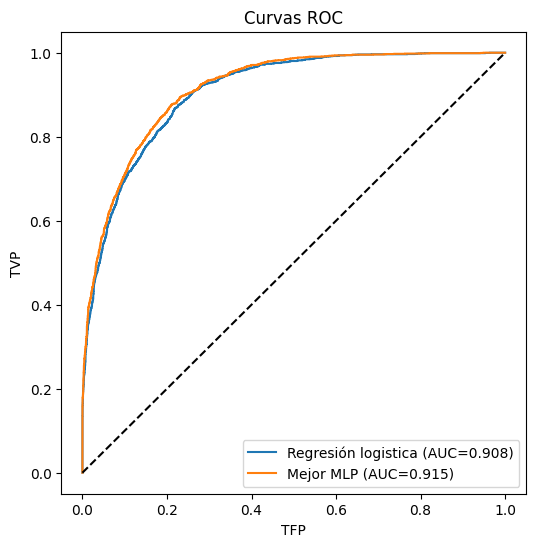

In [24]:
# Gráfica ROC mejor modelo y logistic
from sklearn.metrics import RocCurveDisplay
plt.figure(figsize=(6,6))
# Regresión logistica
fpr_l, tpr_l, _ = roc_curve(y_test, eval_logistic_test_probs)
plt.plot(fpr_l, tpr_l, label=f"Regresión logistica (AUC={logistic_auc:.3f})")
# Mejor mlp
mlp_preds = final_eval['preds']
fpr_m, tpr_m, _ = roc_curve(y_test, mlp_preds)
plt.plot(fpr_m, tpr_m, label=f"Mejor MLP (AUC={final_eval['roc_auc']:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("TFP")
plt.ylabel("TVP")
plt.legend()
plt.title("Curvas ROC")
plt.show()


In [25]:
report_text = """# Reporte – Clasificación de Ingresos

## 1. Decisiones de procesamiento de datos

- **Uso de características**:
  Se utilizaron todas las variables originales del dataset *Adult* (edad, nivel educativo, ocupación, sexo, horas por semana, etc.). No se crearon variables nuevas derivadas de combinaciones.

- **Tratamiento de valores faltantes**:
  - Variables numéricas → imputadas con la **mediana**.
  - Variables categóricas → imputadas con el valor `"Unknown"`.

- **Transformaciones aplicadas**:
  - **Numéricas**: estandarización con `StandardScaler` (media 0, varianza 1).
  - **Categóricas**: codificación con **One-Hot Encoding** (`OneHotEncoder`).

- **Balanceo de clases**:
  Se aplicó **SMOTE (Synthetic Minority Oversampling Technique)** para crear ejemplos sintéticos de la clase minoritaria (>50K), corrigiendo el desbalance.

- **Separación de conjuntos**:
  - `train`: entrenamiento del modelo.
  - `validación`: comparación de configuraciones (hiperparámetros).
  - `Prueba final`: evaluación del mejor modelo, sin usarse en fases anteriores.

---

## 2. Hiperparámetros del mejor MLP

El mejor modelo fue **Experimento4**, con la siguiente configuración base:

- Arquitectura: `[1024, 512]` (dos capas ocultas de 1024 y 512 neuronas).
- Función de activación: ReLU.
- Dropout: `0.3`.
- Learning rate: `1e-4`.
- Weight decay (regularización L2): `1e-3`.
- Batch size: `1024`.
- Épocas máximas: `60`.

### Variantes probadas en la arquitectura
Durante los experimentos se probaron también:
- `[1024, 512, 256]`
- `[1024, 512, 128]`
- `[1024, 512, 2]`

En todos los casos, el modelo con arquitectura `[1024, 512]` se mantuvo como el más robusto y con mejor desempeño en validación y test, superando a los **experimentos 1, 2, 3 y 5**.

### Comparación con y sin regularización
- **Sin regularización** (exp1, dropout=0, weight_decay=0):
  - Training loss bajó rápidamente, pero validation loss se disparó → Esto es un síntoma de *overfitting*.
  - AUC menor en validación.

- **Con regularización (Experimento4)**:
  - Training y validation loss se mantuvieron cercanos y estables.
  - Mejor **ROC AUC = 0.915** en test.

👉 **Conclusión**: La mejor combinación fue una red de alta capacidad con regularización adecuada, que evitó el sobreajuste y mejoró la generalización.

---

## 3. Comparación del mejor MLP vs regresión logística

- **Regresión logística (baseline)**:
  - ROC AUC en test: **0.9075**
  - Ventajas: simple, interpretable, muy competitivo.

- **Mejor MLP (exp4)**:
  - ROC AUC en test: **0.9147**
  - Accuracy: **0.827**
  - Precision: **0.597**
  - Recall: **0.829**
  - F1: **0.694**

### Interpretación
- Ambos modelos presentan un rendimiento sólido y acertado.
- El MLP mejora ligeramente el AUC respecto a la regresión logística (0.7 puntos por encima de la regresión logística).
- El MLP captura mejor relaciones no lineales entre variables.
- Sin embargo, la regresión logística sigue siendo una opción fuerte si se prioriza la simplicidad e interpretabilidad.

👉 **Conclusión**
El MLP es superior en desempeño, pero la ganancia debe evaluarse frente al mayor costo computacional ya que este necesitó de más ram y se necesitó correrlo mediante GPU y puede ser más difícil de interpretar.
"""

with open("REPORT.md","w") as f:
    f.write(report_text)

print("REPORT.md")


REPORT.md
